We study GPR methods by comparing them with other modeling and prediction approaches, including polynomial regression,
k-NN, and neural networks. The window size of the moving average is 30-day. The length of log-difference is 7-day.

1. GPR modeling comparision

In [46]:
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from matplotlib.dates import MonthLocator, DateFormatter
from numpy.polynomial.polynomial import Polynomial
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# Load the dataset

# Load the dataset
data_path = 'UK_2022_2023.csv'  # Update with the correct path to your dataset
data_df = pd.read_csv(data_path)

# Convert 'Date' to datetime format and process the data
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%m/%d/%Y')

# Apply a moving average (30-day window)
data_df['Cases_MA'] = data_df['Cases'].rolling(window=30).mean()

# Calculate Delta_7 = log(I(i)) - log(I(i-7)) for smoothed data
data_df['Delta_7'] = np.log10(data_df['Cases_MA']) - np.log10(data_df['Cases_MA'].shift(7))
data_df = data_df.dropna(subset=['Delta_7'])  # Remove missing values

# Prepare data for Gaussian Process modeling
X = np.arange(len(data_df)).reshape(-1, 1).astype(np.float64)  # Time index as the input
Y = data_df['Delta_7'].values.reshape(-1, 1).astype(np.float64)  # The 7-day log differences

# Define the Squared Exponential kernel
kernel = gpflow.kernels.SquaredExponential()

# Define the GP model
model = gpflow.models.GPR(data=(X, Y), kernel=kernel, likelihood=gpflow.likelihoods.Gaussian(variance_lower_bound=0.002))

# Set up the optimizer
opt = gpflow.optimizers.Scipy()

# Train the model
opt.minimize(model.training_loss, model.trainable_variables)

# Make predictions on the same X values
mean, var = model.predict_f(X)

# Convert the tensor to NumPy arrays and then flatten
mean = mean.numpy().flatten()
var = var.numpy().flatten()

# Compute the 95% confidence intervals
lower_bound = mean - 1.96 * np.sqrt(var)
upper_bound = mean + 1.96 * np.sqrt(var)

# Calculate how many points fall within the 95% confidence interval
within_ci_count = np.sum((Y.flatten() >= lower_bound) & (Y.flatten() <= upper_bound))
total_points = len(Y)
percent_within_ci = (within_ci_count / total_points) * 100

# Print the percentage of points within the 95% CI
print(f"Percentage of points within the 95% confidence interval: {percent_within_ci:.2f}%")


Percentage of points within the 95% confidence interval: 98.18%


In [47]:
# Advanced sinusoidal feature generation
def add_advanced_sinusoidal_features(X, n_frequencies=5):
    features = [X]
    for i in range(1, n_frequencies + 1):
        features.append(np.sin(2 * np.pi * i * X / len(X)))
        features.append(np.cos(2 * np.pi * i * X / len(X)))
    return np.hstack(features)

# Generate advanced features
X_advanced = add_advanced_sinusoidal_features(X)

# Neural Network with advanced sinusoidal features
nn_advanced = MLPRegressor(
    hidden_layer_sizes=(200, 150, 100),  # Larger network
    activation='tanh',
    solver='adam',
    learning_rate_init=0.0001,
    max_iter=15000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

# Create pipeline with scaling
pipeline = make_pipeline(StandardScaler(), nn_advanced)

# Train the advanced neural network
pipeline.fit(X_advanced, Y.flatten())
nn_pred_advanced = pipeline.predict(X_advanced)

# Confidence intervals for Advanced Neural Network
residuals_nn_advanced = Y.flatten() - nn_pred_advanced
nn_advanced_std = np.std(residuals_nn_advanced)
nn_lower_bound_advanced = nn_pred_advanced - 1.96 * nn_advanced_std
nn_upper_bound_advanced = nn_pred_advanced + 1.96 * nn_advanced_std

# Calculate MSE for advanced Neural Network
mse_nn_advanced = mean_squared_error(Y, nn_pred_advanced)
print(f"MSE for Advanced Neural Network: {mse_nn_advanced:.6f}")

# Calculate how many data points are within the 95% CI
nn_within_ci_advanced = np.sum((Y.flatten() >= nn_lower_bound_advanced) & (Y.flatten() <= nn_upper_bound_advanced))
nn_percent_within_ci_advanced = (nn_within_ci_advanced / total_points) * 100

print(f"Advanced Neural Network: {nn_within_ci_advanced} out of {total_points} data points ({nn_percent_within_ci_advanced:.2f}%) are within the 95% CI.")

MSE for Advanced Neural Network: 0.000090
Advanced Neural Network: 308 out of 330 data points (93.33%) are within the 95% CI.


In [48]:
# K-NN model
knn = KNeighborsRegressor(n_neighbors=15)
knn.fit(X, Y)
knn_pred = knn.predict(X)

# Polynomial Regression (12th Order)
poly_degree = 20
poly = Polynomial.fit(X.flatten(), Y.flatten(), deg=poly_degree)
poly_pred = poly(X.flatten())



# Confidence intervals for K-NN
residuals_knn = Y.flatten() - knn_pred.flatten()
knn_std = np.std(residuals_knn)
knn_lower_bound = knn_pred.flatten() - 1.96 * knn_std
knn_upper_bound = knn_pred.flatten() + 1.96 * knn_std



# Calculate MSE for both models
mse_knn = mean_squared_error(Y, knn_pred)
mse_poly = mean_squared_error(Y, poly_pred)
mse_gp = mean_squared_error(Y, mean)


# Confidence intervals for Polynomial Regression
residuals_poly = Y.flatten() - poly_pred
poly_std = np.std(residuals_poly)
poly_lower_bound = poly_pred - 1.96 * poly_std
poly_upper_bound = poly_pred + 1.96 * poly_std

# Calculate how many data points are within the 95% CI
knn_within_ci = np.sum((Y.flatten() >= knn_lower_bound) & (Y.flatten() <= knn_upper_bound))
poly_within_ci = np.sum((Y.flatten() >= poly_lower_bound) & (Y.flatten() <= poly_upper_bound))

total_points = len(Y)
knn_percent_within_ci = (knn_within_ci / total_points) * 100
poly_percent_within_ci = (poly_within_ci / total_points) * 100




MSE for K-NN: 0.000080
MSE for Polynomial Regression (Degree 20): 0.000048
MSE for Advanced Neural Network: 0.000090
MSE for Gaussian Process Regression : 0.000069


<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:29: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:29: SyntaxWarning: invalid escape sequence '\D'
C:\Users\bshe6\AppData\Local\Temp\1\ipykernel_17336\1736591286.py:10: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(data_df['Date'], mean, label='$m_{\Delta}(t)-GPR$', color='#ff4500',linewidth =10, alpha=0.75, linestyle='solid')
C:\Users\bshe6\AppData\Local\Temp\1\ipykernel_17336\1736591286.py:18: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(data_df['Date'], Y, 'o', label='$\Delta(t)$-Data', color='#fde725ff', markersize = 9)
C:\Users\bshe6\AppData\Local\Temp\1\ipykernel_17336\1736591286.py:29: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta(t)$',fontsize = 60)
C:\Users\bshe6\AppData\Local\Temp\1\ipykernel_17336\1736591286.py:9: UserWarning: linest

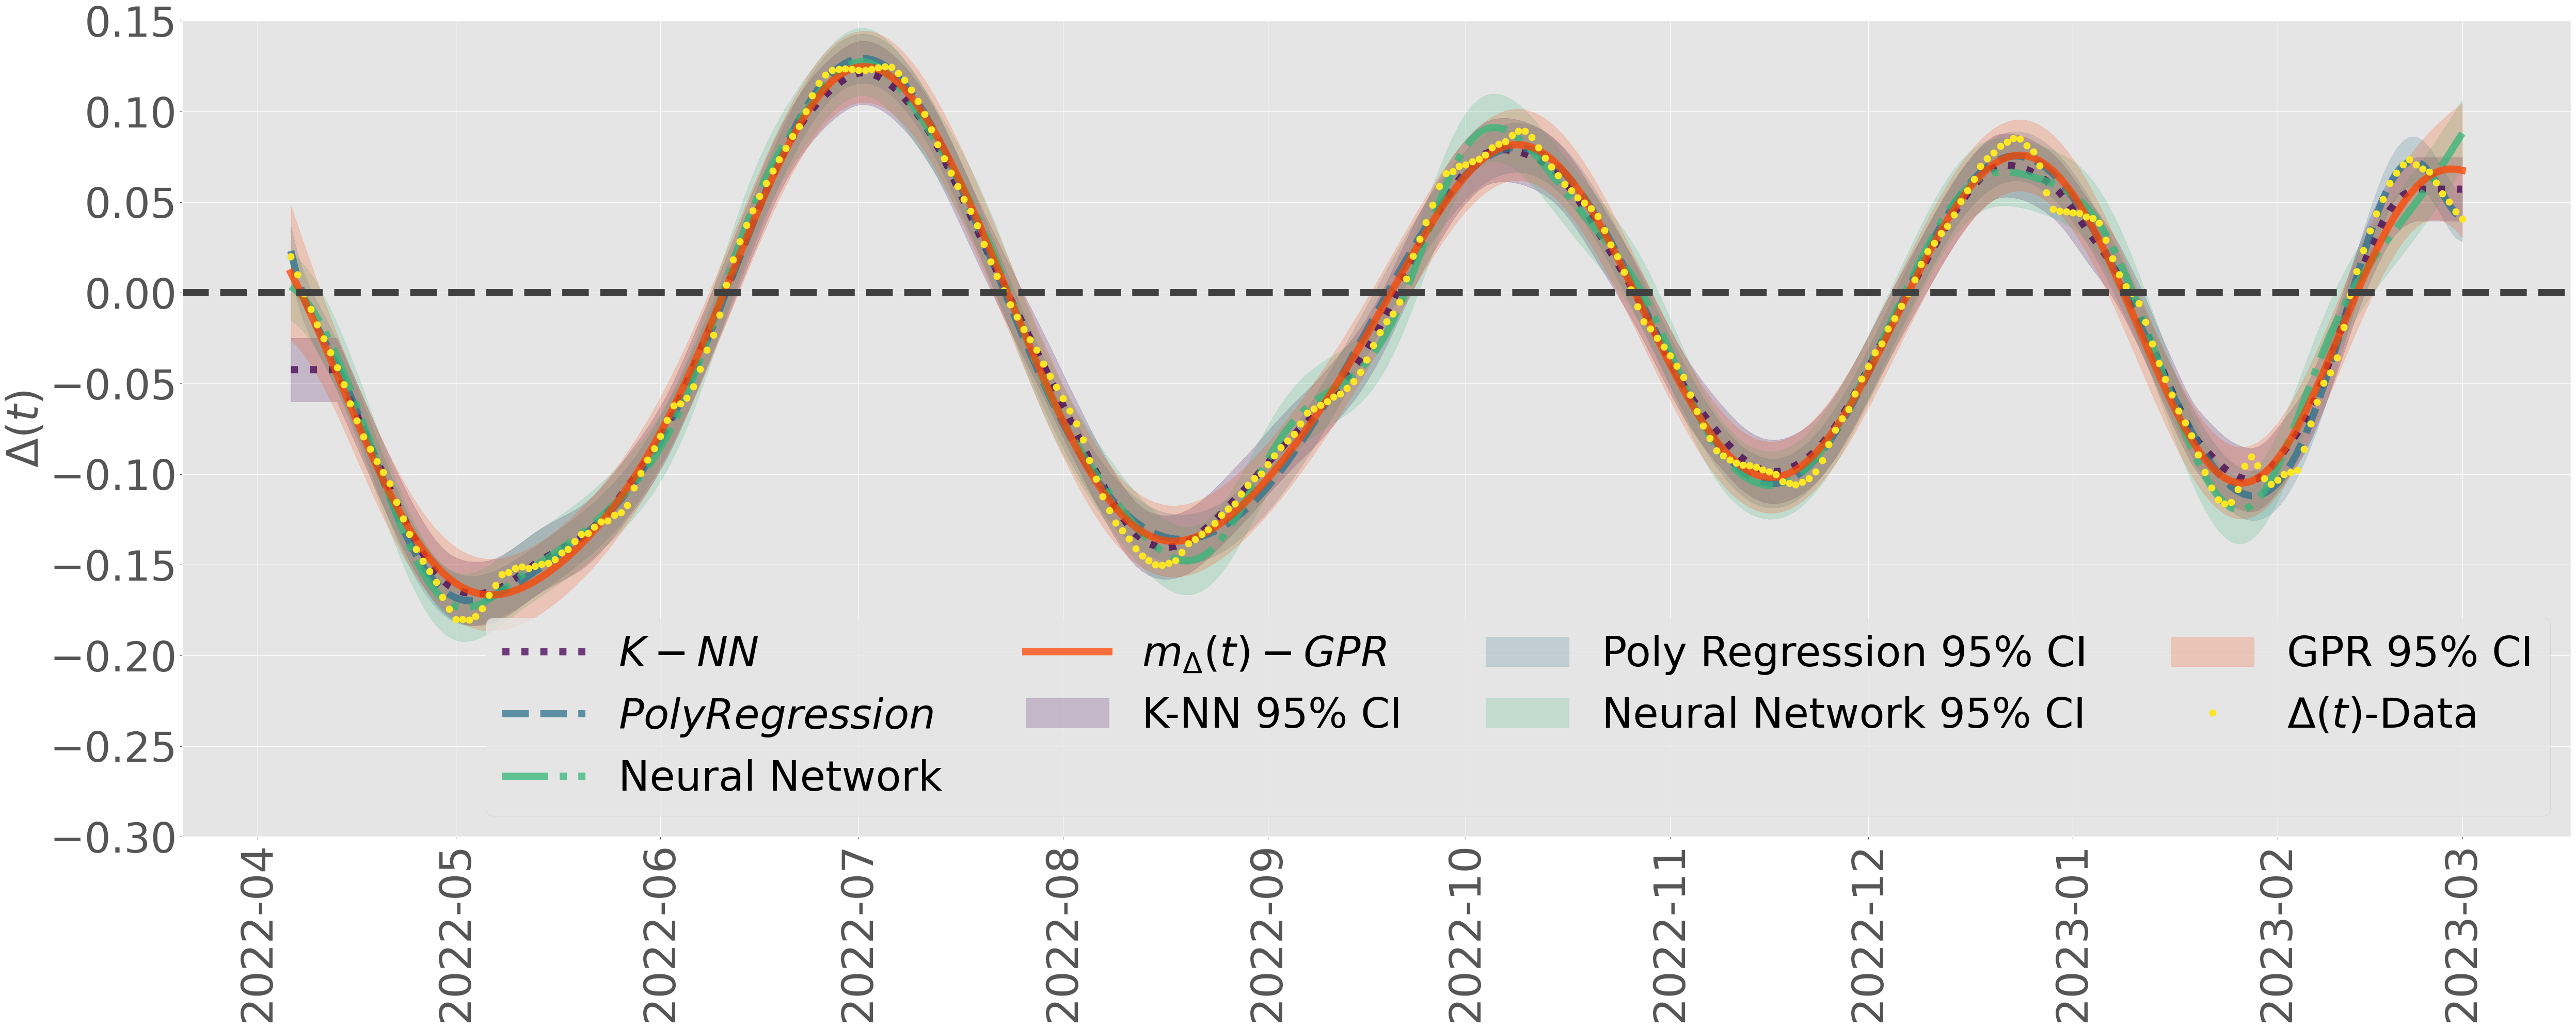

MSE for K-NN: 0.000080
MSE for Polynomial Regression (Degree 20): 0.000048
MSE for Advanced Neural Network: 0.000090
MSE for Gaussian Process Regression : 0.000069
K-NN: 322 out of 330 data points (97.58%) are within the 95% CI.
Polynomial Regression: 309 out of 330 data points (93.64%) are within the 95% CI.
Advanced Neural Network: 308 out of 330 data points (93.33%) are within the 95% CI.
Gaussian Process Regression: Percentage of points within the 95% confidence interval: 98.18%


In [50]:
# Plot the original data, GP predictions, and 95% confidence intervals
plt.style.use('ggplot')
plt.figure(figsize=(50, 20))



plt.plot(data_df['Date'], knn_pred,  label='$K-NN$', color='#440154ff',linewidth = 10, alpha=0.75, linestyle='dotted')
plt.plot(data_df['Date'], poly_pred, label='$Poly Regression$' ,color='#2c728eff',linewidth = 10, alpha=0.75, linestyle='dashed')
plt.plot(data_df['Date'], nn_pred_advanced, '-.', label='Neural Network', color='#35b779ff', linewidth=10, alpha=0.75, linestyle='dashdot')
plt.plot(data_df['Date'], mean, label='$m_{\Delta}(t)-GPR$', color='#ff4500',linewidth =10, alpha=0.75, linestyle='solid')


plt.fill_between(data_df['Date'], knn_lower_bound, knn_upper_bound, color='#440154ff', alpha=0.2, label='K-NN 95% CI')
plt.fill_between(data_df['Date'], poly_lower_bound, poly_upper_bound, color = '#2c728eff', alpha=0.2, label='Poly Regression 95% CI')
plt.fill_between(data_df['Date'], nn_lower_bound_advanced, nn_upper_bound_advanced, color='#35b779ff', alpha=0.2, label='Neural Network 95% CI')
plt.fill_between(data_df['Date'], lower_bound, upper_bound, color='#ff4500', alpha=0.2, label='GPR 95% CI')

plt.plot(data_df['Date'], Y, 'o', label='$\Delta(t)$-Data', color='#fde725ff', markersize = 9)

# Add a horizontal dashed line at zero
plt.axhline(0, color='#404040', linestyle='--', linewidth = 10)

# Set date format for x-axis to display weekly
plt.gca().xaxis.set_major_locator(MonthLocator())  # Set x-axis to show every 7 days (weekly)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))  # Format dates
plt.xticks(fontsize = 55)
plt.yticks(fontsize = 58)
#plt.xlabel('Date')
plt.ylabel('$\Delta(t)$',fontsize = 60)
#plt.title('Gaussian Process Model with 95% Confidence Interval')
plt.xticks(rotation=90)  # Rotate date labels for better readability
plt.legend(fontsize = 58, loc='lower right', ncol= 4)  # Add legend
plt.xticks(fontsize = 60)
plt.yticks(fontsize = 58)

ax = plt.gca()
ax.set_ylim([-0.3, 0.15])

plt.tight_layout()
plt.savefig('GP_Modeling.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"MSE for K-NN: {mse_knn:.6f}")
print(f"MSE for Polynomial Regression (Degree {poly_degree}): {mse_poly:.6f}")
print(f"MSE for Advanced Neural Network: {mse_nn_advanced:.6f}")
print(f"MSE for Gaussian Process Regression : {mse_gp:.6f}")


print(f"K-NN: {knn_within_ci} out of {total_points} data points ({knn_percent_within_ci:.2f}%) are within the 95% CI.")
print(f"Polynomial Regression: {poly_within_ci} out of {total_points} data points ({poly_percent_within_ci:.2f}%) are within the 95% CI.")
print(f"Advanced Neural Network: {nn_within_ci_advanced} out of {total_points} data points ({nn_percent_within_ci_advanced:.2f}%) are within the 95% CI.")
print(f"Gaussian Process Regression: Percentage of points within the 95% confidence interval: {percent_within_ci:.2f}%")

2. GPR prediction comparision

In [51]:
import numpy as np
import gpflow
from gpflow.kernels import SquaredExponential
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from numpy.polynomial.polynomial import Polynomial
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [52]:

# Load the dataset
data_path = 'UK_2022_2023.csv'
data_df = pd.read_csv(data_path)
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%m/%d/%Y')
data_df['Cases_MA'] = data_df['Cases'].rolling(window=30).mean()
data_df['Delta_7'] = np.log10(data_df['Cases_MA']) - np.log10(data_df['Cases_MA'].shift(7))
data_df = data_df.dropna(subset=['Delta_7']).reset_index(drop=True)  # Reset index after NaN removal

# Prepare the data
X = np.arange(len(data_df)).reshape(-1, 1).astype(np.float64)
Y = data_df['Delta_7'].values.reshape(-1, 1).astype(np.float64)
dates = data_df['Date']

# Sliding window parameters
window_size = 30
prediction_steps = 20

# Initialize storage
predictions_gpr, predictions_knn, predictions_poly, predictions_nn = [], [], [], []
gpr_ci_lower, gpr_ci_upper = [], []
knn_ci_lower, knn_ci_upper = [], []
poly_ci_lower, poly_ci_upper = [], []
nn_ci_lower, nn_ci_upper = [], []
indices = []

# GPR Training
kernel = SquaredExponential()
opt = gpflow.optimizers.Scipy()

# K-NN Model
knn = KNeighborsRegressor(n_neighbors=3)

# Polynomial Regression
poly_degree = 3

# Neural Network Model
nn_basic = MLPRegressor(
    hidden_layer_sizes=(50, 25, 10),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=10000,
    random_state=42,
    early_stopping=True
)
pipeline_basic = make_pipeline(StandardScaler(), nn_basic)

# Sliding window loop
for start in range(0, len(Y) - window_size - prediction_steps + 1, prediction_steps):
    X_train = X[start:start + window_size]
    Y_train = Y[start:start + window_size]
    X_test = X[start + window_size:start + window_size + prediction_steps]
    Y_test = Y[start + window_size:start + window_size + prediction_steps]

    valid_indices = list(range(start + window_size, start + window_size + len(X_test)))
    indices.extend(valid_indices)

    # GPR Model
    model = gpflow.models.GPR(data=(X_train, Y_train), kernel=kernel, likelihood=gpflow.likelihoods.Gaussian(variance_lower_bound=0.002))
    opt.minimize(model.training_loss, model.trainable_variables)
    gpr_mean, gpr_var = model.predict_f(X_test)
    predictions_gpr.extend(gpr_mean.numpy().flatten())
    gpr_ci_lower.extend(gpr_mean.numpy().flatten() - 1.96 * np.sqrt(gpr_var.numpy().flatten()))
    gpr_ci_upper.extend(gpr_mean.numpy().flatten() + 1.96 * np.sqrt(gpr_var.numpy().flatten()))
    
    # K-NN Predictions
    knn.fit(X_train, Y_train)
    knn_pred = knn.predict(X_test)
    predictions_knn.extend(knn_pred.flatten())
    knn_residuals = Y_test.flatten() - knn_pred
    knn_std = np.std(knn_residuals)
    knn_ci_lower.extend(knn_pred.flatten() - 1.96 * knn_std)
    knn_ci_upper.extend(knn_pred.flatten() + 1.96 * knn_std)

    # Polynomial Regression Predictions
    poly_model = Polynomial.fit(np.arange(window_size), Y_train.flatten(), deg=poly_degree)
    poly_pred = poly_model(np.arange(window_size, window_size + len(X_test)))
    predictions_poly.extend(poly_pred.flatten())
    poly_residuals = Y_test.flatten() - poly_pred
    poly_std = np.std(poly_residuals)
    poly_ci_lower.extend(poly_pred.flatten() - 1.96 * poly_std)
    poly_ci_upper.extend(poly_pred.flatten() + 1.96 * poly_std)

    # Neural Network Predictions
    pipeline_basic.fit(X_train, Y_train.flatten())
    nn_pred = pipeline_basic.predict(X_test)
    predictions_nn.extend(nn_pred.flatten())
    nn_residuals = Y_test.flatten() - nn_pred
    nn_std = np.std(nn_residuals)
    nn_ci_lower.extend(nn_pred.flatten() - 1.96 * nn_std)
    nn_ci_upper.extend(nn_pred.flatten() + 1.96 * nn_std)

# Convert predictions to numpy arrays
predictions_gpr = np.array(predictions_gpr)
gpr_ci_lower, gpr_ci_upper = np.array(gpr_ci_lower), np.array(gpr_ci_upper)

predictions_knn = np.array(predictions_knn)
knn_ci_lower, knn_ci_upper = np.array(knn_ci_lower), np.array(knn_ci_upper)

predictions_poly = np.array(predictions_poly)
poly_ci_lower, poly_ci_upper = np.array(poly_ci_lower), np.array(poly_ci_upper)

predictions_nn = np.array(predictions_nn)
nn_ci_lower, nn_ci_upper = np.array(nn_ci_lower), np.array(nn_ci_upper)

indices = np.array(indices)

# Align indices with dates
aligned_dates = dates.iloc[indices].reset_index(drop=True)

# Compute how many predictions fall within the 95% confidence intervals
def ci_coverage(actual, lower, upper):
    return np.sum((actual >= lower) & (actual <= upper)) / len(actual) * 100

within_ci_gpr = ci_coverage(Y[indices].flatten(), gpr_ci_lower, gpr_ci_upper)
within_ci_knn = ci_coverage(Y[indices].flatten(), knn_ci_lower, knn_ci_upper)
within_ci_poly = ci_coverage(Y[indices].flatten(), poly_ci_lower, poly_ci_upper)
within_ci_nn = ci_coverage(Y[indices].flatten(), nn_ci_lower, nn_ci_upper)



<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:29: SyntaxWarning: invalid escape sequence '\D'
<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:29: SyntaxWarning: invalid escape sequence '\D'
C:\Users\bshe6\AppData\Local\Temp\1\ipykernel_17336\67491402.py:23: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(dates, Y.flatten(), 'o', label='$\Delta(t)$-Data', color='#fde725ff', markersize = 9, alpha = 0.7)
C:\Users\bshe6\AppData\Local\Temp\1\ipykernel_17336\67491402.py:29: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta_7$ (Log Differences)', fontsize=16)


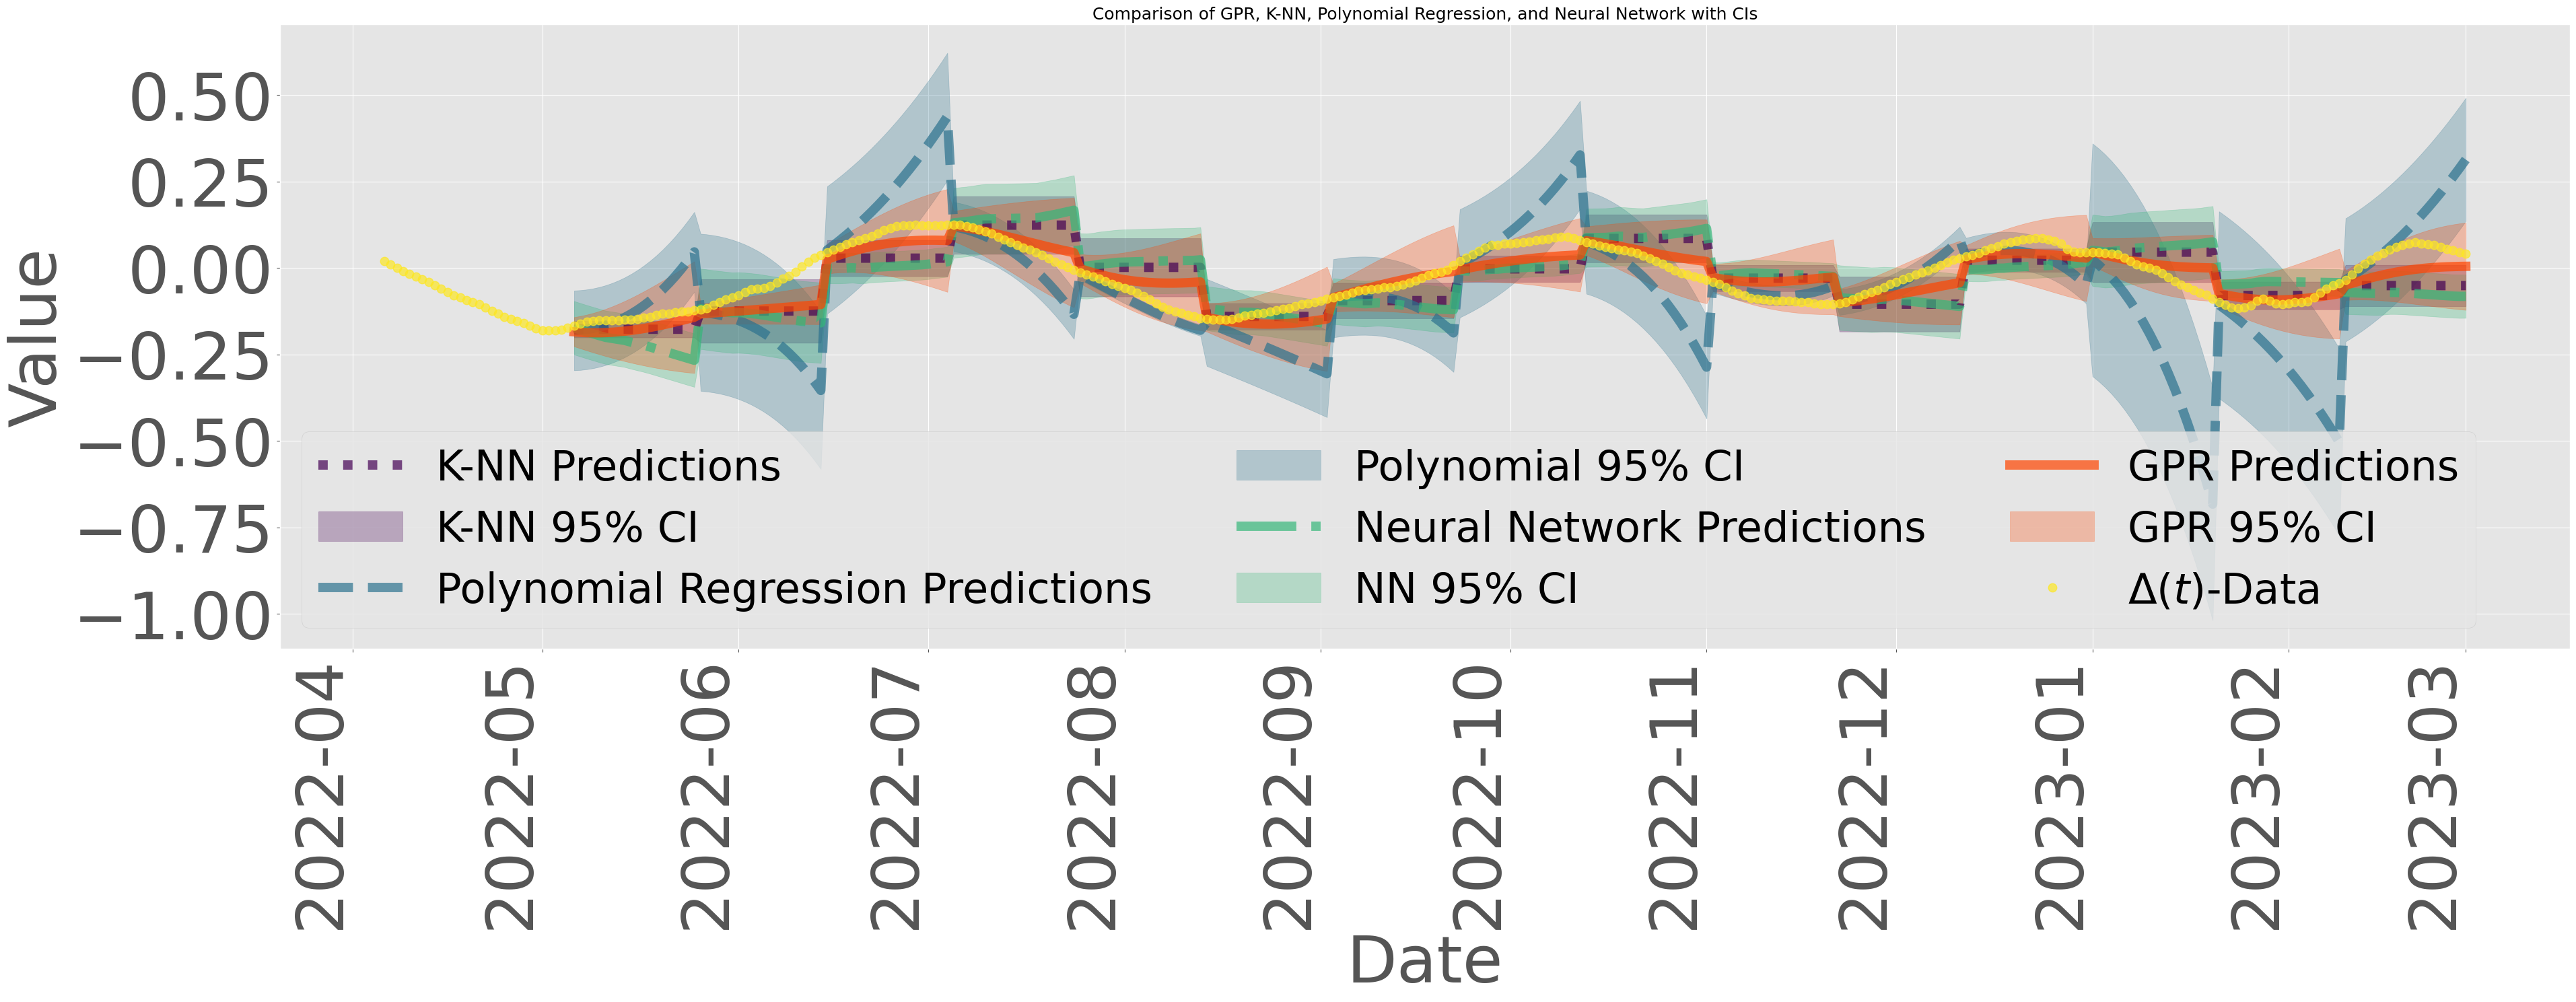

Mean Squared Errors (MSE):
GPR: 0.0019
K-NN: 0.0046
Polynomial Regression: 0.0183
Neural Network: 0.0070
Mean Squared Errors (MSE):Percentage of points within the 95% confidence interval:
GPR: 94.0000
K-NN: 51.0000
Polynomial Regression: 72.0000
Neural Network: 43.6667


In [53]:
# Plot the original data, GP predictions, and 95% confidence intervals
plt.style.use('ggplot')
plt.figure(figsize=(40, 15))


# K-NN Plot
plt.plot(aligned_dates, predictions_knn, label='K-NN Predictions', color='#440154ff',linewidth = 10, alpha=0.7, linestyle='dotted')
plt.fill_between(aligned_dates, knn_ci_lower, knn_ci_upper, color='#440154ff', alpha=0.28, label='K-NN 95% CI')

# Polynomial Regression Plot
plt.plot(aligned_dates, predictions_poly, label='Polynomial Regression Predictions', color='#2c728eff',linewidth = 10, alpha=0.7, linestyle='dashed')
plt.fill_between(aligned_dates, poly_ci_lower, poly_ci_upper, color='#2c728eff', alpha=0.28, label='Polynomial 95% CI')

# Neural Network Plot
plt.plot(aligned_dates, predictions_nn, label='Neural Network Predictions', color='#35b779ff', linewidth=10, alpha=0.7, linestyle='dashdot')
plt.fill_between(aligned_dates, nn_ci_lower, nn_ci_upper, color='#35b779ff', alpha=0.28, label='NN 95% CI')

# GPR Plot
plt.plot(aligned_dates, predictions_gpr, label='GPR Predictions', color='#ff4500',linewidth =10, alpha=0.7, linestyle='solid')
plt.fill_between(aligned_dates, gpr_ci_lower, gpr_ci_upper, color='#ff4500', alpha=0.28, label='GPR 95% CI')

# Plot Actual Data
plt.plot(dates, Y.flatten(), 'o', label='$\Delta(t)$-Data', color='#fde725ff', markersize = 9, alpha = 0.7)


# Formatting
plt.title('Comparison of GPR, K-NN, Polynomial Regression, and Neural Network with CIs', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('$\Delta_7$ (Log Differences)', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(rotation=45)
plt.xlabel('Date',fontsize = 70)
plt.ylabel('Value',fontsize = 70)
#plt.title('Posterior Mean with Confidence Intervals and True Data',fontsize = 40)
plt.gcf().autofmt_xdate()  # Rotate date labels
plt.xticks(rotation=90)
plt.xticks(fontsize = 70)
plt.yticks(fontsize = 70)
plt.legend(fontsize = 45, ncol=3)
plt.grid(True)
plt.tight_layout()
plt.savefig('Combined_Model_Predictions_with_CIs.png', dpi=300, bbox_inches='tight')
plt.show()

# Compute MSE for each model
mse_gpr = mean_squared_error(Y[indices], predictions_gpr)
mse_knn = mean_squared_error(Y[indices], predictions_knn)
mse_poly = mean_squared_error(Y[indices], predictions_poly)
mse_nn = mean_squared_error(Y[indices], predictions_nn)

print(f"Mean Squared Errors (MSE):")
print(f"GPR: {mse_gpr:.4f}")
print(f"K-NN: {mse_knn:.4f}")
print(f"Polynomial Regression: {mse_poly:.4f}")
print(f"Neural Network: {mse_nn:.4f}")

print(f"Mean Squared Errors (MSE):"f"Percentage of points within the 95% confidence interval:")
print(f"GPR: {within_ci_gpr:.4f}")
print(f"K-NN: {within_ci_knn:.4f}")
print(f"Polynomial Regression: {within_ci_poly:.4f}")
print(f"Neural Network: {within_ci_nn:.4f}")